# Phase 2: Adding More Features

Phase 1 worked okay with just 3 features and it just for verify the dateset.

Now add some features to see if clustering gets better

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt
import seaborn as sns

## Load data first

In [56]:
# load the data
df = pd.read_csv('../data/processed/full_market_matrix.csv', parse_dates=['Date'])

print("Shape:", df.shape)
print("Dates:", df['Date'].min(), "to", df['Date'].max())
print("\nColumns:", len(df.columns))
print(df.columns.tolist())

df.head()

Shape: (2926, 22)
Dates: 2018-01-01 00:00:00 to 2026-01-04 00:00:00

Columns: 22
['Date', 'AAVE', 'ADA', 'ALGO', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'FIL', 'LINK', 'LTC', 'MATIC', 'SOL', 'TRX', 'UNI', 'VET', 'XLM', 'XRP', 'fg_raw']


,Date,AAVE,ADA,ALGO,ATOM,AVAX,BNB,BTC,DOGE,DOT,...,LINK,LTC,MATIC,SOL,TRX,UNI,VET,XLM,XRP,fg_raw
0,2018-01-01,NaN,0.728657,NaN,NaN,NaN,8.41461,13657.200195,0.008909,NaN,...,0.733563,229.033005,NaN,NaN,0.051695,NaN,NaN,0.480008,2.39103,NaN
1,2018-01-02,NaN,0.782587,NaN,NaN,NaN,8.83777,14982.099609,0.009145,NaN,...,0.673712,255.684006,NaN,NaN,0.078682,NaN,NaN,0.564766,2.48090,NaN
2,2018-01-03,NaN,1.079660,NaN,NaN,NaN,9.53588,15201.000000,0.009320,NaN,...,0.681167,245.367996,NaN,NaN,0.094703,NaN,NaN,0.896227,3.10537,NaN
3,2018-01-04,NaN,1.114120,NaN,NaN,NaN,9.21399,15599.200195,0.009644,NaN,...,0.984368,241.369995,NaN,NaN,0.207974,NaN,NaN,0.724050,3.19663,NaN
4,2018-01-05,NaN,0.999559,NaN,NaN,NaN,14.91720,17429.500000,0.012167,NaN,...,0.907486,249.270996,NaN,NaN,0.220555,NaN,NaN,0.662712,3.04871,NaN


## Quick check: reproduce Phase 1 baseline

Before adding new features, let me reproduce what I got in Phase 1

In [57]:
# same 3 features from Phase 1
df['ret_btc'] = np.log(df['BTC'] / df['BTC'].shift(1))
df['vol_btc_7'] = df['ret_btc'].rolling(7).std() * np.sqrt(365)
df['fg_norm'] = df['fg_raw'] / 100

print("Created baseline features")
print("ret_btc sample:", df['ret_btc'].dropna().head(3).values)
print("vol_btc_7 sample:", df['vol_btc_7'].dropna().head(3).values)

# clean up
baseline_df = df[['Date', 'ret_btc', 'vol_btc_7', 'fg_norm']].dropna()
print(f"\nAfter dropna: {len(baseline_df)} rows")

# standardize
scaler = StandardScaler()
X_baseline = scaler.fit_transform(baseline_df[['ret_btc', 'vol_btc_7', 'fg_norm']])

# cluster with k=4 (what I found best in Phase 1)
best_k = 4
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km.fit_predict(X_baseline)

# check score
sil = silhouette_score(X_baseline, labels)
print(f"\nPhase 1 baseline Silhouette: {sil:.4f}")
print("as before")

Created baseline features
ret_btc sample: [0.09258926 0.01450509 0.02585843]
vol_btc_7 sample: [1.37019645 1.2396126  1.25201965]

After dropna: 2895 rows

Phase 1 baseline Silhouette: 0.3024
as before


In [ ]:
# Statistical properties of BTC returns (just for report)
print("BTC Returns Statistical Properties")

mean_daily = df['ret_btc'].mean()
std_daily = df['ret_btc'].std()
mean_annual = mean_daily * 365
std_annual = std_daily * np.sqrt(365)

print(f"\nDaily returns:")
print(f"  Mean: {mean_daily:.6f} ({mean_daily*100:.4f}%)")
print(f"  Std:  {std_daily:.6f} ({std_daily*100:.4f}%)")

print(f"\nAnnualized  (here for report):")
print(f"  Mean: {mean_annual:.6f} ({mean_annual*100:.2f}%)")
print(f"  Std:  {std_annual:.6f} ({std_annual*100:.2f}%)")

print(f"\n7-day rolling volatility:")
print(f"  Mean: {df['vol_btc_7'].mean():.4f} ({df['vol_btc_7'].mean()*100:.2f}%)")
print("=" * 60)

BTC Returns Statistical Properties

Daily returns:
  Mean: 0.000650 (0.0650%)
  Std:  0.034230 (3.4230%)

Annualized  (here for report):
  Mean: 0.237235 (23.72%)
  Std:  0.653968 (65.40%)

7-day rolling volatility:
  Mean: 0.5581 (55.81%)


## 2. Multi-Asset Feature Engineering

Now extend to multi-asset features using all 20 cryptocurrencies.

### Try adding market breadth stuff

Measure how many assets are participating in market moves.

In [58]:
# get all coin columns (exclude Date, fg_raw, and any derived features)
coin_cols = [col for col in df.columns if col not in ['Date', 'fg_raw', 'ret_btc', 'vol_btc_7', 'fg_norm']]
print("Coins:", len(coin_cols))
print(coin_cols[:5], "...")  # dont print all

# calculate returns for all coins
for coin in coin_cols:
    df[f'ret_{coin}'] = np.log(df[coin] / df[coin].shift(1))

print("\nCalculated returns for all coins")

#pct_positive: how many coins have positive returns each day
ret_cols = [f'ret_{coin}' for coin in coin_cols]
df['pct_positive'] = (df[ret_cols] > 0).sum(axis=1) / len(coin_cols)

print("pct_positive sample:")
print(df['pct_positive'].dropna().head()) # drop na, because first 49 days will be NaN

# try MA50 thing
for coin in coin_cols:
    df[f'ma50_{coin}'] = df[coin].rolling(50).mean()

ma_cols = [f'ma50_{coin}' for coin in coin_cols]

# how many coins are above their MA50 each day
df['pct_above_ma50'] = sum(df[coin] > df[f'ma50_{coin}'] for coin in coin_cols) / len(coin_cols)

print("\nStats:")
print("pct_positive:", df['pct_positive'].describe())
print("pct_above_ma50:", df['pct_above_ma50'].describe())

print("\npct_above_ma50 sample:")
print(df['pct_above_ma50'].dropna().tail())

Coins: 20
['AAVE', 'ADA', 'ALGO', 'ATOM', 'AVAX'] ...

Calculated returns for all coins
pct_positive sample:
0    0.00
1    0.50
2    0.45
3    0.40
4    0.35
Name: pct_positive, dtype: float64

Stats:
pct_positive: count    2926.000000
mean        0.441302
std         0.335007
min         0.000000
25%         0.100000
50%         0.400000
75%         0.750000
max         1.000000
Name: pct_positive, dtype: float64
pct_above_ma50: count    2926.000000
mean        0.398838
std         0.339208
min         0.000000
25%         0.100000
50%         0.300000
75%         0.700000
max         1.000000
Name: pct_above_ma50, dtype: float64

pct_above_ma50 sample:
2921    0.05
2922    0.10
2923    0.45
2924    0.45
2925    0.70
Name: pct_above_ma50, dtype: float64


## Correlation features

Maybe correlation can show if everything moves together, use for measure the correlation among different coins.

In [59]:
# BTC-ETH correlation (30 day window)
df['btc_eth_corr_30d'] = df['ret_BTC'].rolling(30).corr(df['ret_ETH'])

print("BTC-ETH corr sample:")
print(df['btc_eth_corr_30d'].dropna().head())

# try mean correlation for all pairs
# this might take a while...
def calc_mean_pairwise_corr(window=30):
    corr_values = []
    for i in range(window-1, len(df)):  # -1 is bc start from 29th day
        window_data = df[ret_cols].iloc[i-window+1:i+1]
        corr_matrix = window_data.corr()
        # only upper triangle, becasue the matric is symmetical, BTC-ETH = ETH-BTC
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        mean_corr = upper_tri.stack().mean()
        corr_values.append(mean_corr)
    return [np.nan] * (window-1) + corr_values

print("\nCalculating mean pairwise corr...")
df['mean_pairwise_corr'] = calc_mean_pairwise_corr(30)

print("\nStats:")
print(df[['btc_eth_corr_30d', 'mean_pairwise_corr']].describe())

BTC-ETH corr sample:
30    0.722344
31    0.710733
32    0.694189
33    0.699970
34    0.753770
Name: btc_eth_corr_30d, dtype: float64

Calculating mean pairwise corr...

Stats:
       btc_eth_corr_30d  mean_pairwise_corr
count       2896.000000         2897.000000
mean           0.834744            0.613609
std            0.101430            0.137152
min            0.358429            0.193420
25%            0.782062            0.518743
50%            0.859018            0.629697
75%            0.911074            0.724340
max            0.983087            0.883591


## Volatility dispersion

Check if vol spreads across coins or stays in some coins

In [60]:
# calculate 7day vol for each coin, based on annually window
for coin in coin_cols:
    df[f'vol_7d_{coin}'] = df[f'ret_{coin}'].rolling(7).std() * np.sqrt(365)

vol_cols = [f'vol_7d_{coin}' for coin in coin_cols]

print("Created vol columns")
print("Sample vol_7d_BTC:")
print(df['vol_7d_BTC'].dropna().head())

# std of all vols
df['vol_dispersion'] = df[vol_cols].std(axis=1)

# std of all returns
df['ret_dispersion'] = df[ret_cols].std(axis=1)

print("\nDispersion features:")
print("vol_dispersion:", df['vol_dispersion'].describe())
print("ret_dispersion:", df['ret_dispersion'].describe())

Created vol columns
Sample vol_7d_BTC:
7     1.370196
8     1.239613
9     1.252020
10    1.439857
11    1.099398
Name: vol_7d_BTC, dtype: float64

Dispersion features:
vol_dispersion: count    2919.000000
mean        0.690740
std         1.167192
min         0.055713
25%         0.250647
50%         0.379492
75%         0.786790
max        21.163440
Name: vol_dispersion, dtype: float64
ret_dispersion: count    2925.000000
mean        0.042234
std         0.067979
min         0.004962
25%         0.018521
50%         0.027024
75%         0.045187
max         2.158057
Name: ret_dispersion, dtype: float64


In [61]:
# list all features
feature_cols = [
    'ret_btc',           # baseline
    'vol_btc_7',         # baseline  
    'fg_norm',           # baseline
    'pct_positive',      # new: market breadth
    'pct_above_ma50',    # new: market breadth
    'btc_eth_corr_30d',  # new: correlation
    'mean_pairwise_corr',# new: correlation
    'vol_dispersion',    # new: volatility
    'ret_dispersion'     # new: volatility
]

print("Total features:", len(feature_cols))
for i, f in enumerate(feature_cols, 1):
    print(f"{i}. {f}")

# clean data
df_enhanced = df[['Date'] + feature_cols].dropna()

print(f"\nAfter dropna: {df_enhanced.shape}")
print(f"Dates: {df_enhanced['Date'].min()} to {df_enhanced['Date'].max()}")

# quick check for NaN
print("\nAny NaN left?")
print(df_enhanced.isnull().sum())

Total features: 9
1. ret_btc
2. vol_btc_7
3. fg_norm
4. pct_positive
5. pct_above_ma50
6. btc_eth_corr_30d
7. mean_pairwise_corr
8. vol_dispersion
9. ret_dispersion

After dropna: (2895, 10)
Dates: 2018-02-01 00:00:00 to 2026-01-04 00:00:00

Any NaN left?
Date                  0
ret_btc               0
vol_btc_7             0
fg_norm               0
pct_positive          0
pct_above_ma50        0
btc_eth_corr_30d      0
mean_pairwise_corr    0
vol_dispersion        0
ret_dispersion        0
dtype: int64


## Check correlation between features

Don't want too correlated features

In [76]:
# after feature selection, use the selected features
# (will be updated after running selection above)
# for now, test with all features to see the problem

feature_cols_all = [
    'ret_btc', 'vol_btc_7', 'fg_norm',
    'pct_positive', 'pct_above_ma50', 'btc_eth_corr_30d',
    'mean_pairwise_corr', 'vol_dispersion', 'ret_dispersion'
]

# standardize
X_for_k = df_enhanced[feature_cols_all].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_k)

# try k from 2 to 10
k_range = range(2, 11)
wcss = []
silhouette_scores = []
db_scores = []

print("Testing k from 2 to 10 with all features...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    wcss.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    
    silhouette_scores.append(sil)
    db_scores.append(db)
    
    print(f"k={k}  Sil={sil:.4f}  DB={db:.4f}")

best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nBest k by Silhouette: {best_k} (score={max(silhouette_scores):.4f})")
print("Note: this is with all 9 features, performance is worse than baseline")

Testing k from 2 to 10 with all features...
k=2  Sil=0.2394  DB=1.7018
k=3  Sil=0.1792  DB=1.6799
k=4  Sil=0.1829  DB=1.3113
k=5  Sil=0.1683  DB=1.5319
k=6  Sil=0.1699  DB=1.2662
k=7  Sil=0.1665  DB=1.2836
k=8  Sil=0.1561  DB=1.3243
k=9  Sil=0.1604  DB=1.3198
k=10  Sil=0.1626  DB=1.2963

Best k by Silhouette: 2 (score=0.2394)
Note: this is with all 9 features, performance is worse than baseline


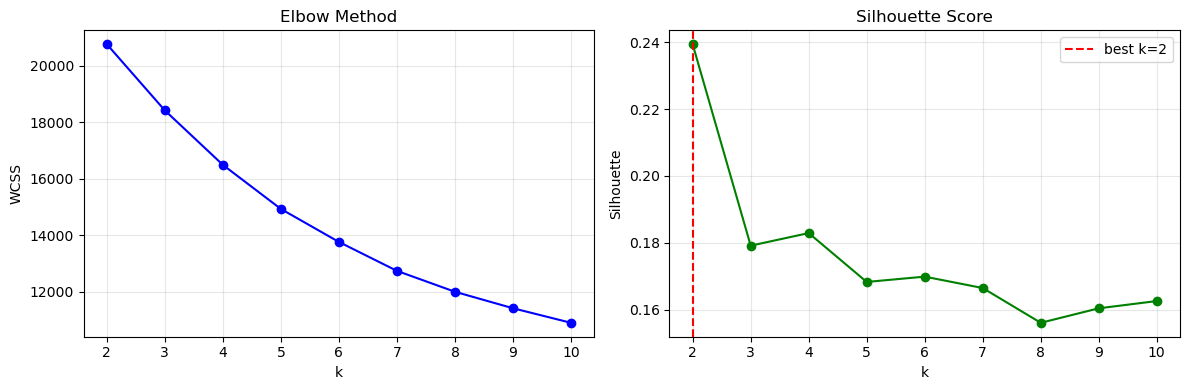


Phase 1 used k=2, still good for Phase 2
Will use k=2


In [63]:
# plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# elbow
axes[0].plot(k_range, wcss, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('WCSS')
axes[0].set_title('Elbow Method')
axes[0].grid(alpha=0.3)

# silhouette
axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].axvline(x=best_k, color='red', linestyle='--', label=f'best k={best_k}')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette Score')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nPhase 1 used k=2, still good for Phase 2")
print(f"Will use k={best_k}")

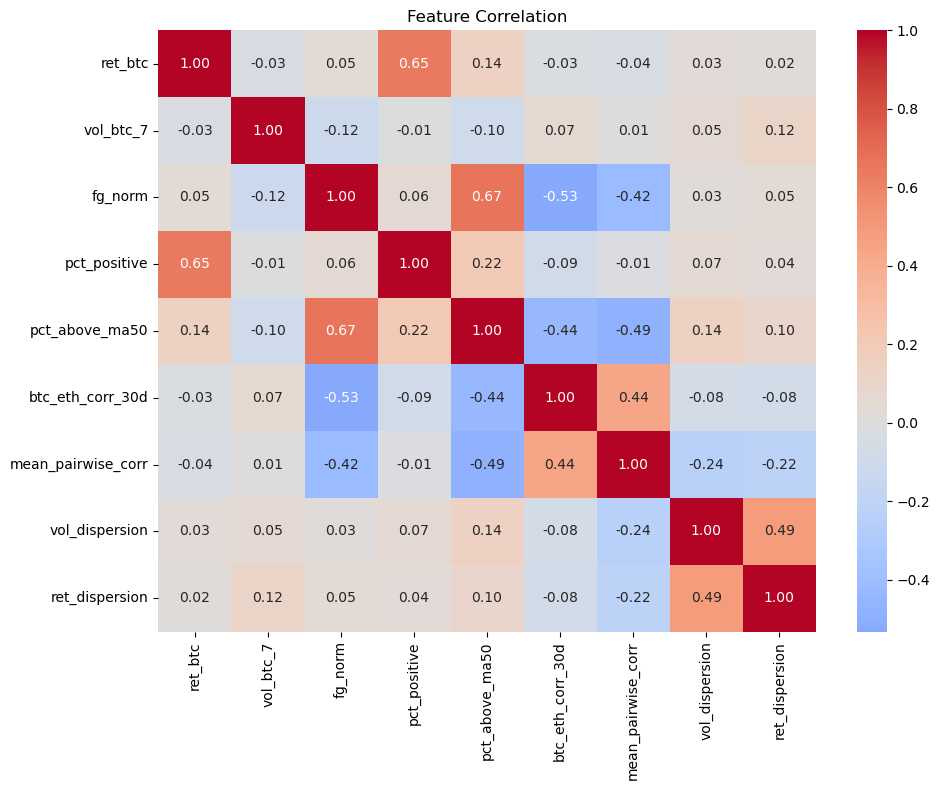


Looking for high correlations (>0.8)...
Found high correlations:
No high correlations, tthats mean good


In [64]:
# correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df_enhanced[feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

# check high corr
print("\nLooking for high correlations (>0.8)...")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))

print("Found high correlations:")
if high_corr:
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("No high correlations, tthats mean good")

In [65]:
# greedy forward selection: keep adding features that improve
selected_features = baseline.copy()
remaining_features = candidates.copy()
current_sil = baseline_sil

print(f"Starting: {selected_features}")
print(f"Starting sil: {current_sil:.4f}\n")

iteration = 1
while remaining_features:
    print(f"Iteration {iteration}:")
    best_improvement = 0
    best_feat = None
    best_sil = current_sil
    
    for feat in remaining_features:
        test_features = selected_features + [feat]
        X_test = df_enhanced[test_features].values
        scaler_test = StandardScaler()
        X_scaled_test = scaler_test.fit_transform(X_test)
        km_test = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels_test = km_test.fit_predict(X_scaled_test)
        sil = silhouette_score(X_scaled_test, labels_test)
        improvement = sil - current_sil
        print(f"  + {feat:<25} {sil:.4f}  ({improvement:+.4f})")
        
        if improvement > best_improvement:
            best_improvement = improvement
            best_feat = feat
            best_sil = sil
    
    if best_improvement <= 0:
        print("No improvement, stopping")
        break
    
    print(f"  -> Adding {best_feat}\n")
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    current_sil = best_sil
    iteration += 1

print(f"\nFinal selected features ({len(selected_features)}): {selected_features}")
print(f"Final sil: {current_sil:.4f}")
print(f"\nCompare: baseline=0.30, all 9 features=0.24, selected={current_sil:.4f}")

Starting: ['ret_btc', 'vol_btc_7', 'fg_norm']
Starting sil: 0.2892

Iteration 1:
  + pct_positive              0.2830  (-0.0061)
  + pct_above_ma50            0.3300  (+0.0409)
  + btc_eth_corr_30d          0.2828  (-0.0064)
  + mean_pairwise_corr        0.2379  (-0.0513)
  + vol_dispersion            0.2543  (-0.0348)
  + ret_dispersion            0.2592  (-0.0299)
  -> Adding pct_above_ma50

Iteration 2:
  + pct_positive              0.2715  (-0.0586)
  + btc_eth_corr_30d          0.2968  (-0.0333)
  + mean_pairwise_corr        0.2976  (-0.0324)
  + vol_dispersion            0.3072  (-0.0228)
  + ret_dispersion            0.3089  (-0.0211)
No improvement, stopping

Final selected features (4): ['ret_btc', 'vol_btc_7', 'fg_norm', 'pct_above_ma50']
Final sil: 0.3300

Compare: baseline=0.30, all 9 features=0.24, selected=0.3300


If some features help, try building the best set iteratively

In [ ]:
# test adding one feature at a time
baseline = ['ret_btc', 'vol_btc_7', 'fg_norm']
candidates = ['pct_positive', 'pct_above_ma50', 'btc_eth_corr_30d', 
              'mean_pairwise_corr', 'vol_dispersion', 'ret_dispersion']

# baseline score with k=2 (Fear/Greed)
X_test = df_enhanced[baseline].values
scaler_test = StandardScaler()
X_scaled_test = scaler_test.fit_transform(X_test)
km_test = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_test = km_test.fit_predict(X_scaled_test)
baseline_sil = silhouette_score(X_scaled_test, labels_test)

print(f"Baseline (3 features, k=2): {baseline_sil:.4f}")
print("\nTesting each additional feature (k=2):")

results = []
for feat in candidates:
    current_features = baseline + [feat]
    X_test = df_enhanced[current_features].values
    X_scaled_test = scaler_test.fit_transform(X_test)
    km_test = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels_test = km_test.fit_predict(X_scaled_test)
    sil = silhouette_score(X_scaled_test, labels_test)
    change = sil - baseline_sil
    results.append((feat, sil, change))
    print(f"  + {feat:<25} {sil:.4f}  ({change:+.4f})")

# sort by improvement
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
print("\nRanked by improvement:")
for i, (feat, sil, change) in enumerate(results_sorted, 1):
    status = "keep" if change > 0 else "drop"
    print(f"{i}. {feat:<25} {change:+.4f}  ({status})")

Baseline (3 features): 0.2892

Testing each additional feature:
  + pct_positive              0.2830  (-0.0061)
  + pct_above_ma50            0.3300  (+0.0409)
  + btc_eth_corr_30d          0.2828  (-0.0064)
  + mean_pairwise_corr        0.2379  (-0.0513)
  + vol_dispersion            0.2543  (-0.0348)
  + ret_dispersion            0.2592  (-0.0299)

Ranked by improvement:
1. pct_above_ma50            +0.0409  (keep)
2. pct_positive              -0.0061  (drop)
3. btc_eth_corr_30d          -0.0064  (drop)
4. ret_dispersion            -0.0299  (drop)
5. vol_dispersion            -0.0348  (drop)
6. mean_pairwise_corr        -0.0513  (drop)


## Feature selection test

9 features got Sil=0.24, worse than Phase 1's 3 features (~0.30). Maybe some features are just noise.

Test: add each feature one by one to baseline and see which ones actually help.

Note: using k=2 for feature selection because our goal is Fear/Greed classification. But optimal k might vary with different feature sets.

## Final clustering with selected features

Based on feature selection above, use the best feature set

In [81]:
# use selected features from above
# if no improvement was found, use baseline
# otherwise use the selected feature set
# for now, manually set after running feature selection

# TODO: update this after seeing feature selection results
feature_cols = selected_features  # from greedy selection above

print(f"Using {len(feature_cols)} features: {feature_cols}")

# prepare data
X = df_enhanced[feature_cols].values
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X)

# cluster with k=2 (Fear/Greed interpretation)
final_k = 2
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_scaled_final)

df_enhanced['cluster'] = labels_final

print(f"\nClustering with k={final_k}")
print("Cluster sizes:")
print(df_enhanced['cluster'].value_counts())

# metrics
sil_final = silhouette_score(X_scaled_final, labels_final)
db_final = davies_bouldin_score(X_scaled_final, labels_final)
ch_final = calinski_harabasz_score(X_scaled_final, labels_final)

print(f"\nFinal Model ({len(feature_cols)} features, k={final_k}):")
print(f"Silhouette: {sil_final:.4f}")
print(f"DB Index: {db_final:.4f}")
print(f"CH Score: {ch_final:.2f}")

Using 4 features: ['ret_btc', 'vol_btc_7', 'fg_norm', 'pct_above_ma50']

Clustering with k=2
Cluster sizes:
cluster
0    1571
1    1324
Name: count, dtype: int64

Final Model (4 features, k=2):
Silhouette: 0.3300
DB Index: 1.2350
CH Score: 1396.53


In [83]:
# Output cluster centroids for report
print("\n" + "="*60)
print("CLUSTER CENTROIDS (Standardized Space)")
print("="*60)

centroids = kmeans_final.cluster_centers_

# Create a formatted table
print("\nCluster Centroids:")
print(f"{'Feature':<20} {'Fear (0)':<12} {'Greed (1)':<12} {'Separation (σ)':<15}")
print("-" * 60)

for i, feat in enumerate(feature_cols):
    fear_val = centroids[0][i]
    greed_val = centroids[1][i]
    separation = abs(greed_val - fear_val)
    print(f"{feat:<20} {fear_val:>+8.3f}     {greed_val:>+8.3f}     {separation:>8.3f}")

print("\n" + "="*60)

# Also show which cluster is Fear and which is Greed based on ret_btc
ret_btc_idx = feature_cols.index('ret_btc')
if centroids[0][ret_btc_idx] < centroids[1][ret_btc_idx]:
    print("Cluster 0 = FEAR (negative return)")
    print("Cluster 1 = GREED (positive return)")
else:
    print("Cluster 0 = GREED (positive return)")
    print("Cluster 1 = FEAR (negative return)")
print("="*60)


CLUSTER CENTROIDS (Standardized Space)

Cluster Centroids:
Feature              Fear (0)     Greed (1)    Separation (σ) 
------------------------------------------------------------
ret_btc                -0.107       +0.127        0.234
vol_btc_7              +0.084       -0.100        0.184
fg_norm                -0.692       +0.817        1.509
pct_above_ma50         -0.778       +0.918        1.696

Cluster 0 = FEAR (negative return)
Cluster 1 = GREED (positive return)


In [84]:
# Calculate contribution to total separation (for report table)
print("\nFeature Importance (Contribution to Inertia):")
print("="*60)

separations = []
for i, feat in enumerate(feature_cols):
    fear_val = centroids[0][i]
    greed_val = centroids[1][i]
    separation = abs(greed_val - fear_val)
    separations.append((feat, separation))

# Calculate squared separation (contributes to inertia)
total_squared = sum(s[1]**2 for s in separations)
separations_with_contrib = [(f, s, (s**2 / total_squared) * 100) 
                             for f, s in separations]

# Sort by contribution
separations_with_contrib.sort(key=lambda x: x[2], reverse=True)

print(f"{'Rank':<6} {'Feature':<20} {'Separation':<12} {'Contrib %':<12}")
print("-" * 60)
for rank, (feat, sep, contrib) in enumerate(separations_with_contrib, 1):
    print(f"{rank:<6} {feat:<20} {sep:<12.3f} {contrib:<12.1f}%")

print("="*60)


Feature Importance (Contribution to Inertia):
Rank   Feature              Separation   Contrib %   
------------------------------------------------------------
1      pct_above_ma50       1.696        54.9        %
2      fg_norm              1.509        43.4        %
3      ret_btc              0.234        1.0         %
4      vol_btc_7            0.184        0.6         %


## Visualize clusters with PCA

PCA variance:
PC1: 43.24%
PC2: 24.53%


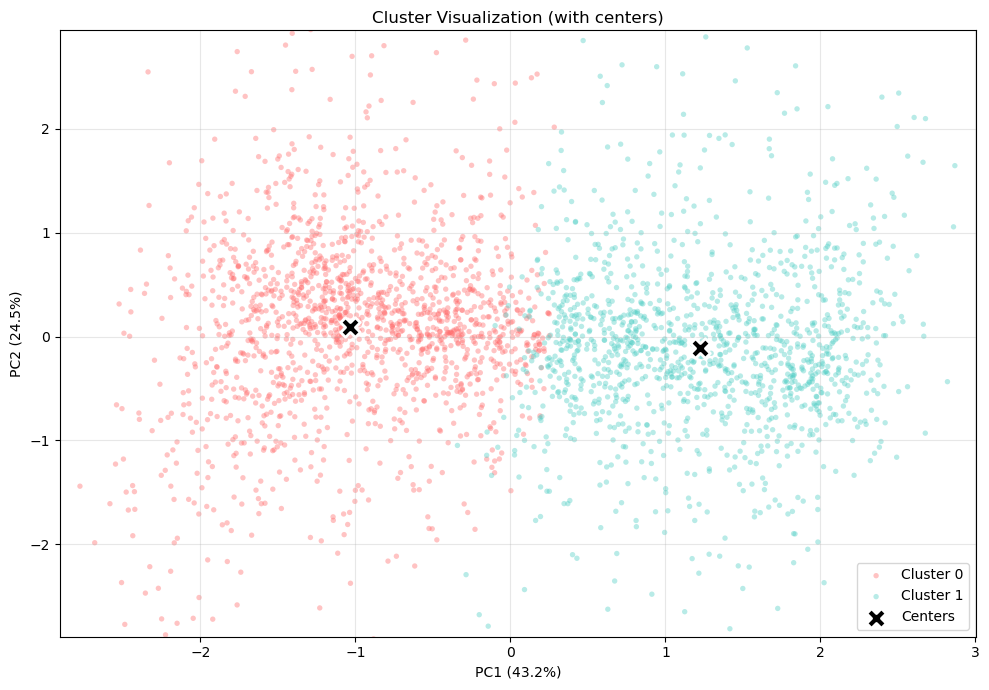

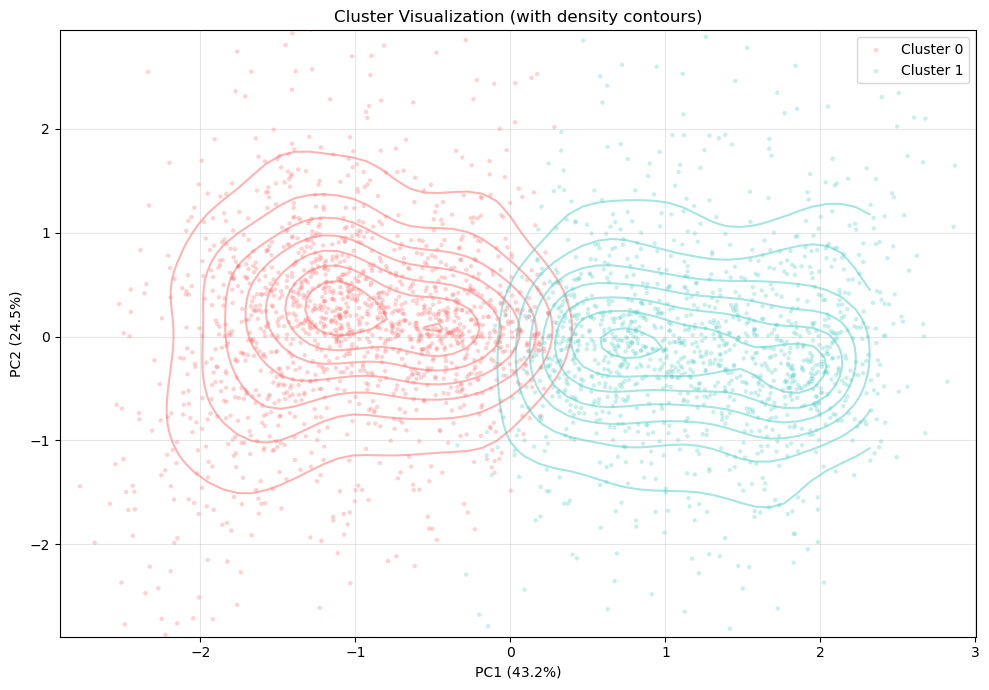


Total variance explained: 67.8%


In [75]:
from sklearn.decomposition import PCA

# PCA for vis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_final)

print("PCA variance:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}") 
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

# use percentiles to avoid outliers stretching the plot
pc1_min, pc1_max = np.percentile(X_pca[:, 0], [2, 98])
pc2_min, pc2_max = np.percentile(X_pca[:, 1], [2, 98])
pc1_margin = (pc1_max - pc1_min) * 0.15
pc2_margin = (pc2_max - pc2_min) * 0.15

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# First plot: scatter with centers
fig1, ax1 = plt.subplots(figsize=(10, 7))

for cluster_id in range(final_k):
    mask = labels_final == cluster_id
    cluster_points = X_pca[mask]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}',
               alpha=0.4, s=15, edgecolors='none')

# add cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='black', marker='X', s=200, edgecolors='white', linewidths=2,
           label='Centers', zorder=10)

ax1.set_xlim(pc1_min - pc1_margin, pc1_max + pc1_margin)
ax1.set_ylim(pc2_min - pc2_margin, pc2_max + pc2_margin)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax1.set_title('Cluster Visualization (with centers)')
ax1.legend()
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Second plot: density contours
fig2, ax2 = plt.subplots(figsize=(10, 7))

for cluster_id in range(final_k):
    mask = labels_final == cluster_id
    cluster_points = X_pca[mask]
    ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}',
               alpha=0.3, s=10, edgecolors='none')

# add contour lines to show density
from scipy.stats import gaussian_kde
for cluster_id in range(final_k):
    mask = labels_final == cluster_id
    cluster_points = X_pca[mask]
    if len(cluster_points) > 50:
        try:
            kde = gaussian_kde(cluster_points.T)
            xx, yy = np.meshgrid(np.linspace(pc1_min, pc1_max, 50),
                                np.linspace(pc2_min, pc2_max, 50))
            z = kde(np.vstack([xx.ravel(), yy.ravel()]))
            ax2.contour(xx, yy, z.reshape(xx.shape), 
                       colors=colors[cluster_id], alpha=0.5, linewidths=1.5)
        except:
            pass

ax2.set_xlim(pc1_min - pc1_margin, pc1_max + pc1_margin)
ax2.set_ylim(pc2_min - pc2_margin, pc2_max + pc2_margin)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax2.set_title('Cluster Visualization (with density contours)')
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal variance explained: {pca.explained_variance_ratio_.sum():.1%}")

## nCluster statistics

In [69]:
# Phase 1 with 3 features got around 0.3 silhouette
# let's see if 9 features are better


Cluster statistics:

Cluster 0: 1571 days
  Mean ret_btc: -0.0029
  Mean vol_btc_7: 0.5799
  Mean fg_norm: 0.3215
  Mean pct_positive: 0.3947

Cluster 1: 1324 days
  Mean ret_btc: 0.0050
  Mean vol_btc_7: 0.5193
  Mean fg_norm: 0.6486
  Mean pct_positive: 0.5012


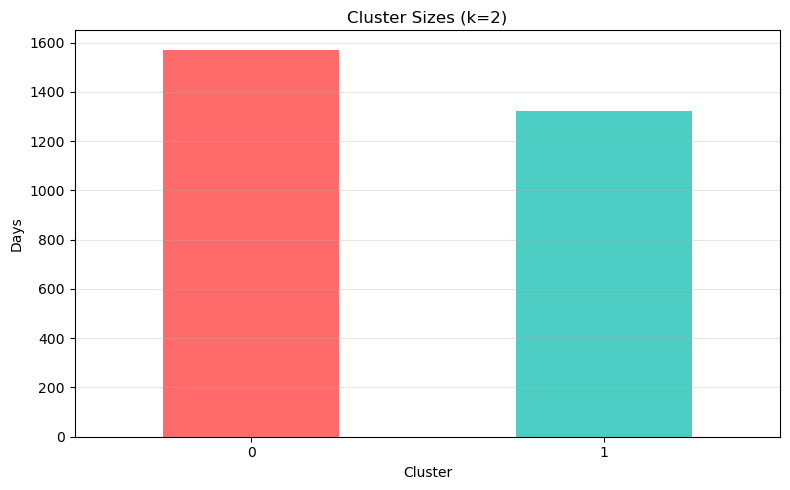

In [80]:
# check cluster stats
print("\nCluster statistics:")
for cluster_id in range(best_k):
    mask = df_enhanced['cluster'] == cluster_id
    cluster_data = df_enhanced[mask]
    
    print(f"\nCluster {cluster_id}: {len(cluster_data)} days")
    print(f"  Mean ret_btc: {cluster_data['ret_btc'].mean():.4f}")
    print(f"  Mean vol_btc_7: {cluster_data['vol_btc_7'].mean():.4f}")
    print(f"  Mean fg_norm: {cluster_data['fg_norm'].mean():.4f}")
    print(f"  Mean pct_positive: {cluster_data['pct_positive'].mean():.4f}")

# plot sizes
plt.figure(figsize=(8, 5))
df_enhanced['cluster'].value_counts().sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.xlabel('Cluster')
plt.ylabel('Days')
plt.title(f'Cluster Sizes (k={best_k})')
plt.xticks(rotation=0)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Complete Statistics for Report - ALL TABLES

This section calculates ALL statistics needed for the report to ensure data consistency.

In [85]:
# ============================================================
# TABLE 3: REGIME CHARACTERISTICS (Section 5.2)
# ============================================================
print("\n" + "="*70)
print("TABLE 3: REGIME CHARACTERISTICS")
print("="*70)

for cluster_id in range(2):
    mask = df_enhanced['cluster'] == cluster_id
    cluster_data = df_enhanced[mask]
    
    # Determine if this is Fear or Greed based on ret_btc
    mean_ret = cluster_data['ret_btc'].mean()
    regime_name = "FEAR" if mean_ret < 0 else "GREED"
    
    print(f"\n{regime_name} (Cluster {cluster_id}):")
    print(f"  Prevalence: {len(cluster_data)} days ({len(cluster_data)/len(df_enhanced)*100:.1f}%)")
    print(f"  Mean Daily Return: {mean_ret*100:.2f}%")
    print(f"  Mean Volatility (vol_btc_7): {cluster_data['vol_btc_7'].mean():.3f}")
    print(f"  Mean Fear & Greed Index (fg_norm): {cluster_data['fg_norm'].mean():.3f}")
    print(f"  Mean Market Breadth (pct_above_ma50): {cluster_data['pct_above_ma50'].mean()*100:.1f}%")

print("\n" + "="*70)


TABLE 3: REGIME CHARACTERISTICS

FEAR (Cluster 0):
  Prevalence: 1571 days (54.3%)
  Mean Daily Return: -0.29%
  Mean Volatility (vol_btc_7): 0.580
  Mean Fear & Greed Index (fg_norm): 0.322
  Mean Market Breadth (pct_above_ma50): 14.0%

GREED (Cluster 1):
  Prevalence: 1324 days (45.7%)
  Mean Daily Return: 0.50%
  Mean Volatility (vol_btc_7): 0.519
  Mean Fear & Greed Index (fg_norm): 0.649
  Mean Market Breadth (pct_above_ma50): 71.5%



In [86]:
# ============================================================
# TABLE 4 & 5: REGIME DURATION AND TRANSITION STATISTICS
# ============================================================
print("\n" + "="*70)
print("TABLE 4: REGIME DURATION STATISTICS")
print("="*70)

# Add a column to track regime runs
df_enhanced['regime_change'] = (df_enhanced['cluster'] != df_enhanced['cluster'].shift(1)).astype(int)
df_enhanced['regime_run_id'] = df_enhanced['regime_change'].cumsum()

# Calculate duration statistics for each regime
for cluster_id in range(2):
    mask = df_enhanced['cluster'] == cluster_id
    regime_name = "FEAR" if cluster_id == 0 else "GREED"
    
    # Get all runs of this regime
    regime_runs = df_enhanced[mask].groupby('regime_run_id').size()
    
    print(f"\n{regime_name} (Cluster {cluster_id}):")
    print(f"  Mean Duration: {regime_runs.mean():.2f} days")
    print(f"  Median Duration: {regime_runs.median():.0f} days")
    print(f"  Max Duration: {regime_runs.max():.0f} days")
    print(f"  # of Periods: {len(regime_runs)}")

print("\n" + "="*70)
print("TABLE 5: TRANSITION PROBABILITIES")
print("="*70)

# Calculate transition matrix
df_enhanced['next_cluster'] = df_enhanced['cluster'].shift(-1)
transitions = df_enhanced[['cluster', 'next_cluster']].dropna()

for from_cluster in range(2):
    from_regime = "FEAR" if from_cluster == 0 else "GREED"
    from_mask = transitions['cluster'] == from_cluster
    total_from = from_mask.sum()
    
    print(f"\nFrom {from_regime} (Cluster {from_cluster}):")
    for to_cluster in range(2):
        to_regime = "FEAR" if to_cluster == 0 else "GREED"
        to_mask = transitions['next_cluster'] == to_cluster
        count = (from_mask & to_mask).sum()
        prob = count / total_from * 100
        print(f"  -> to {to_regime}: {prob:.1f}%")

print("\n" + "="*70)


TABLE 4: REGIME DURATION STATISTICS

FEAR (Cluster 0):
  Mean Duration: 23.10 days
  Median Duration: 4 days
  Max Duration: 177 days
  # of Periods: 68

GREED (Cluster 1):
  Mean Duration: 19.76 days
  Median Duration: 7 days
  Max Duration: 189 days
  # of Periods: 67

TABLE 5: TRANSITION PROBABILITIES

From FEAR (Cluster 0):
  -> to FEAR: 95.7%
  -> to GREED: 4.3%

From GREED (Cluster 1):
  -> to FEAR: 5.1%
  -> to GREED: 94.9%



## Timeline view

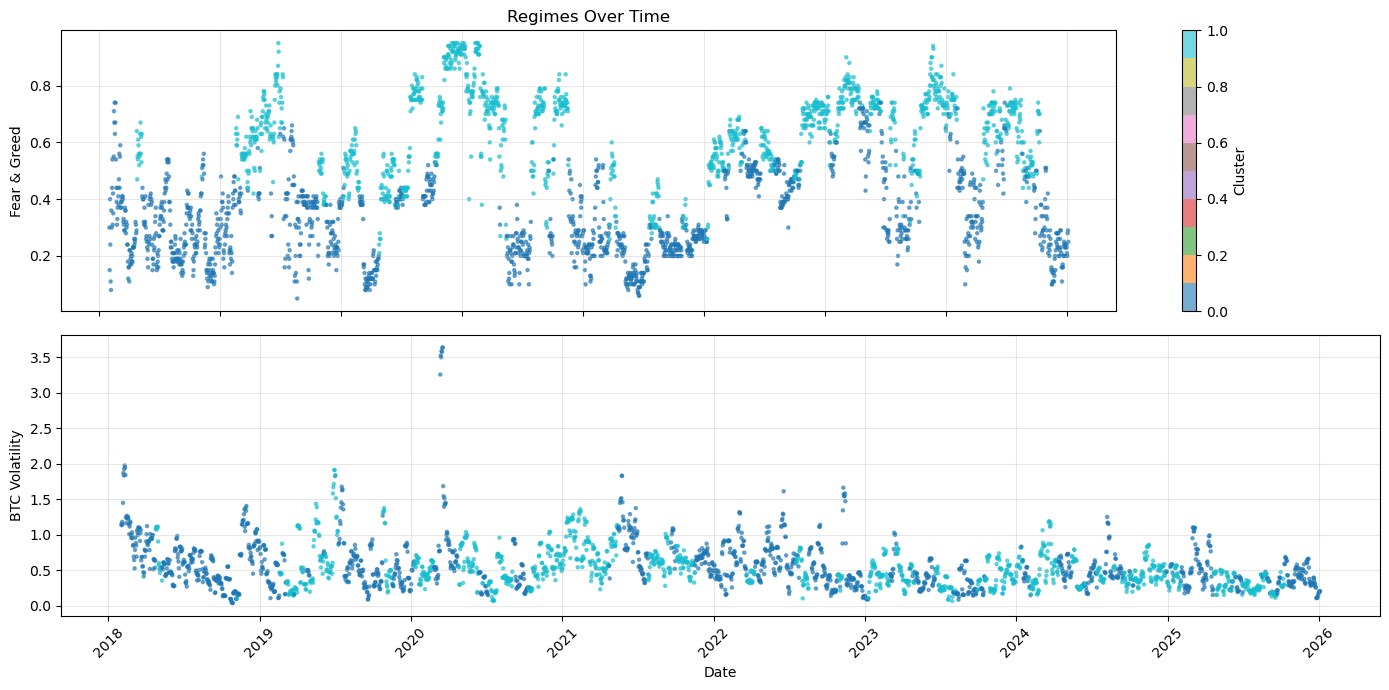

In [71]:
# plot timeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

# F&G over time
scatter = ax1.scatter(df_enhanced['Date'], df_enhanced['fg_norm'], 
                      c=df_enhanced['cluster'], cmap='tab10', s=5, alpha=0.6)
ax1.set_ylabel('Fear & Greed')
ax1.set_title('Regimes Over Time')
ax1.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# Vol over time
ax2.scatter(df_enhanced['Date'], df_enhanced['vol_btc_7'], 
            c=df_enhanced['cluster'], cmap='tab10', s=5, alpha=0.6)
ax2.set_ylabel('BTC Volatility')
ax2.set_xlabel('Date')
ax2.grid(alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()